# VAE Analysis - Faces dataset

## imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## data

In [4]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [5]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## architecture

In [6]:
VAE = load_model(VariationalAutoencoder, RUN_FOLDER)

ValueError: Dimension 0 in both shapes must be equal, but are 3 and 32. Shapes are [3,3,3,32] and [32,3,4,4]. for 'Assign' (op: 'Assign') with input shapes: [3,3,3,32], [32,3,4,4].

## reconstructing faces

Found 202599 images.


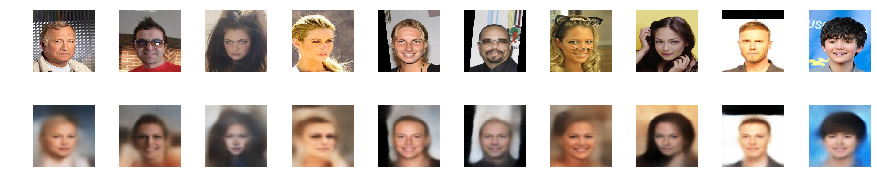

In [30]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = VAE.encoder.predict(example_images)

reconst_images = VAE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


## Latent space distribution

20/20 [==============================] - 2s 115ms/step


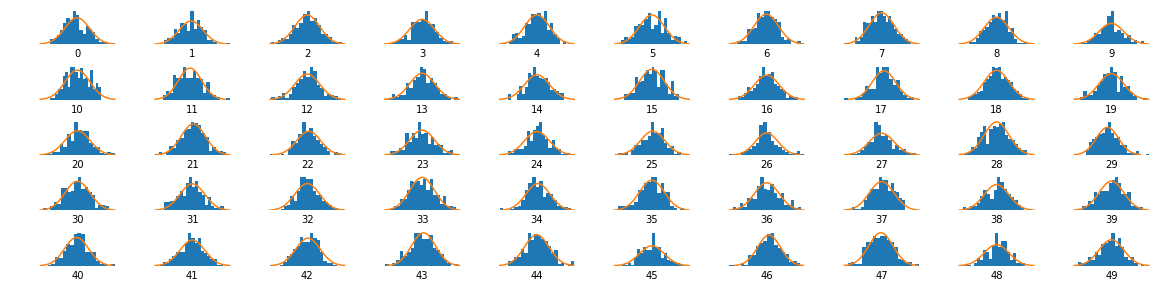

In [31]:
z_test = VAE.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

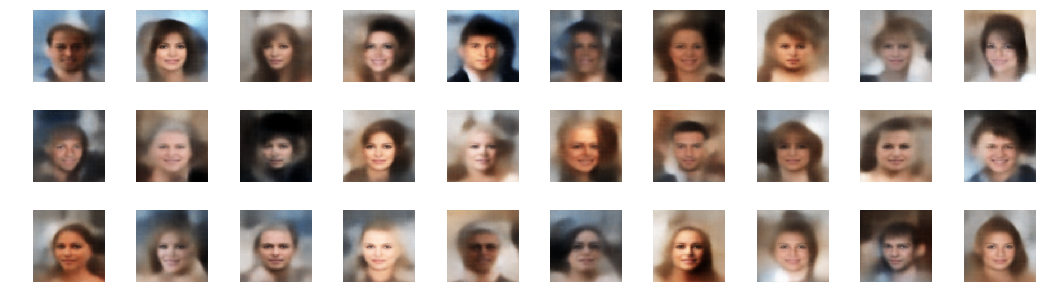

In [32]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,VAE.z_dim))

reconst = VAE.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [89]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = VAE.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = VAE.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = VAE.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [86]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = VAE.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [ ]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

In [90]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 images.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
31    : 2.858    : 0.695    : 3.1    : 3.1
62    : 1.624    : 0.453    : 2.417    : -0.683
97    : 1.094    : 0.259    : 2.058    : -0.36
132    : 0.726    : 0.199    : 2.013    : -0.045
161    : 0.555    : 0.149    : 1.933    : -0.08
190    : 0.446    : 0.123    : 1.842    : -0.091
225    : 0.395    : 0.104    : 1.843    : 0.0
254    : 0.327    : 0.088    : 1.778    : -0.065
285    : 0.3    : 0.079    : 1.739    : -0.039
317    : 0.277    : 0.068    : 1.751    : 0.013
348    : 0.237    : 0.063    : 1.757    : 0.006
382    : 0.213    : 0.061    : 1.769    : 0.012
411    : 0.174    : 0.049    : 1.746    : -0.023
436    : 0.162    : 0.052    : 1.751    : 0.006
474    : 0.195    : 0.043    : 1.759    : 0.008
502    : 0.149    : 0.042    : 1.747    : -0.012
532    : 0.159    : 0.043    : 1.73    : -0.017
568    : 0.144    : 0.035    : 1.755    : 0.025
598    : 0.132    : 0.034    : 1.766    : 0.011
6

In [91]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 images.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
74    : 1.801    : 0.889    : 2.167    : 2.167
149    : 1.083    : 0.476    : 1.952    : -0.216
207    : 0.562    : 0.278    : 1.871    : -0.08
282    : 0.47    : 0.188    : 1.807    : -0.065
360    : 0.413    : 0.154    : 1.784    : -0.022
447    : 0.324    : 0.135    : 1.766    : -0.018
531    : 0.251    : 0.102    : 1.729    : -0.037
601    : 0.202    : 0.091    : 1.744    : 0.015
686    : 0.218    : 0.086    : 1.732    : -0.012
772    : 0.183    : 0.074    : 1.708    : -0.024
861    : 0.167    : 0.058    : 1.693    : -0.016
929    : 0.137    : 0.055    : 1.689    : -0.004
1000    : 0.109    : 0.057    : 1.696    : 0.007
1072    : 0.104    : 0.055    : 1.678    : -0.018
1144    : 0.105    : 0.047    : 1.675    : -0.003
1212    : 0.095    : 0.042    : 1.671    : -0.004
1275    : 0.088    : 0.042    : 1.665    : -0.006
1343    : 0.09    : 0.039    : 1.667    : 0.002
1429    : 0.096    : 0.034   

Eyeglasses Vector


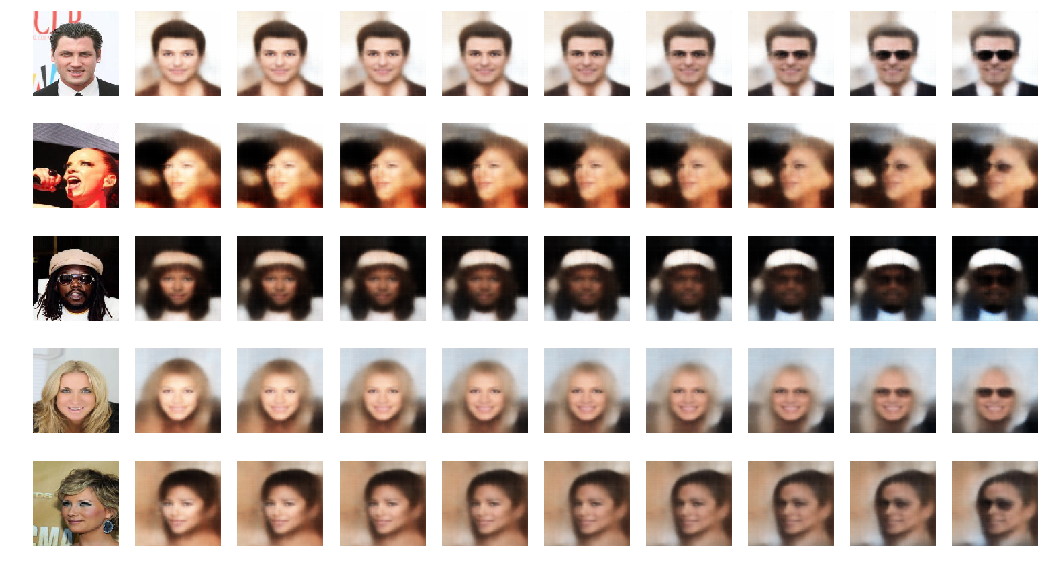

In [116]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [60]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = VAE.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 images.


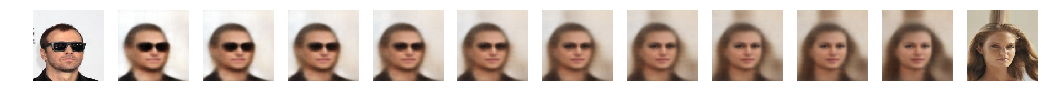

In [70]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 images.


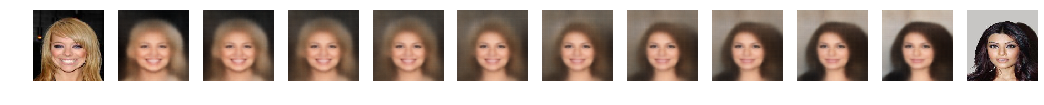

In [68]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 images.


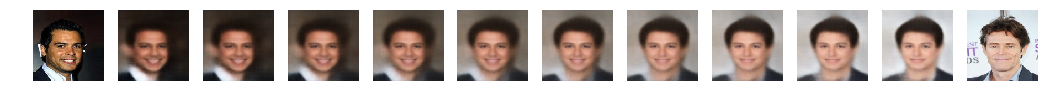

In [136]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)